In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os;
os.chdir("/content/drive/MyDrive/Meal_Behaviour_Analysis");

In [ ]:
import json

# Read the JSON file into a Python object
with open('data.json') as f:
    data = json.load(f)

In [ ]:
import pandas as pd
df = pd.DataFrame(data)

###Food Corpus
* Extracting the data from csv to a list of unique food elements/items.




In [ ]:
food_corpus_df = pd.read_csv("food_corpus.csv")

all_values = []
for col in food_corpus_df.columns:
    all_values.extend(food_corpus_df[col].unique())
food_values = list(set(all_values))

<ipython-input-22-f6859445b935>:1: DtypeWarning: Columns (26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  food_corpus_df = pd.read_csv("food_corpus.csv")


###Tokenization, Lemmatization and Keyword Extraction


*   Tokenization will break a text into individual words or tokens
*   Lemmatization will reduce words to their base or root form.
*   The result is compared with the food corpus list and if present, the keyword is extracted.

In [ ]:
import nltk
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

for index, row in df.iterrows():
    # Extract the sentences from the 'description' column
    sentence = (row['description']).lower()

    tokens = nltk.word_tokenize(sentence)
    filtered_tokens = []

    for token in tokens:
        # Lemmatize the token
        lemmatized_token = lemmatizer.lemmatize(token)

        # Check if the lemmatized token is in the food values list
        if lemmatized_token in food_values:
            filtered_tokens.append(lemmatized_token)

    food_items = ",".join(filtered_tokens)
    df.loc[index, 'Keywords'] = food_items

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


###Data Labelling


*   Data labeling is the process of assigning predefined labels or categories to data instances
*   Here, the data is labelled into breakfast, lunch and dinner accoring to different time slots.


In [ ]:
import datetime
for index, row in df.iterrows():
    time = datetime.datetime.strptime(row['log_time'], "%Y-%m-%d %H:%M:%S")
    if time.hour < 12:
        df.loc[index, "meal_type"] = "breakfast"
    elif time.hour < 18:
        df.loc[index, "meal_type"] = "lunch"
    else:
        df.loc[index, "meal_type"] = "dinner"

In [ ]:
#Order by user id and then date
df=df.sort_values(['user_id','log_time'])

###Visualization of the User's Breakfast (U003)


*   Extract concatenated keywords from Keywords column into individual words.
*   Get the count of number of times the user has eaten that particular food item.
*   Visualize the food items vs count in a bar graph.



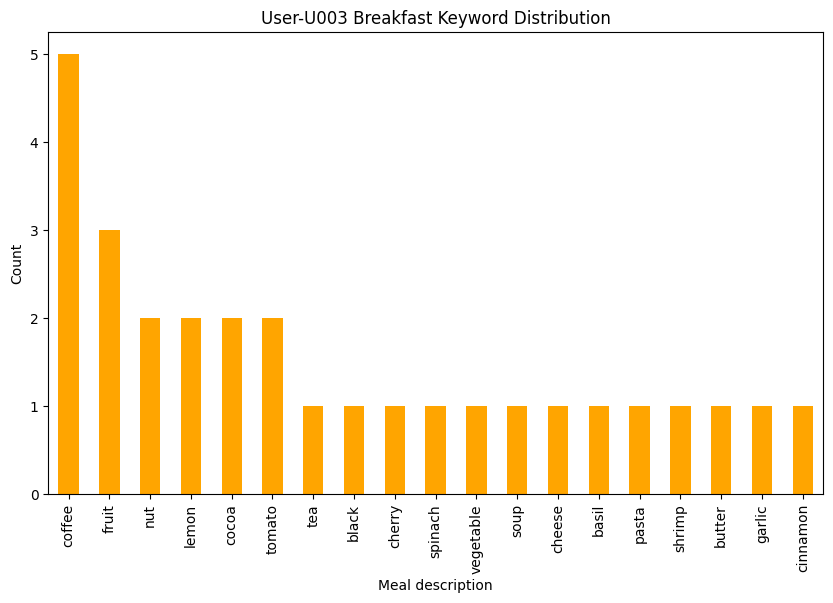

In [ ]:
import matplotlib.pyplot as plt
user_data_breakfast = df[(df['user_id'] == 'U003') & (df['meal_type'] == 'breakfast')]

# Extract keywords during breakfast
result = []
for item in user_data_breakfast['Keywords']:
        if isinstance(item, str):
            result.extend(item.split(','))

result = [item for item in result if item != '']
# Create a DataFrame for breakfast keywords and their counts
breakfast_keywords_counts = pd.Series(result).value_counts()

# Visualize breakfast keyword distribution
plt.figure(figsize=(10, 6))
breakfast_keywords_counts.plot(kind='bar', color='orange')
plt.title(f'User-U003 Breakfast Keyword Distribution')
plt.xlabel('Meal description')
plt.ylabel('Count')
plt.show()

From the above bar graph, we can say that the user - U003 consumes coffee frequently during breakfast. The user also eat fruits, nuts, cocoa and tomato regularly.

###User's Meal Logging Behaviour


*   Calculating mean of the time when user logs their meal (breakfast/lunch/dinner).



In [ ]:
import datetime
from datetime import timedelta

df_filtered = df.loc[(df['user_id'] == 'U001')]

# Convert 'log_time' to datetime.time
df_filtered['log_time'] = pd.to_datetime(df_filtered['log_time']).dt.time

# Convert time objects to seconds
df_filtered['time_seconds'] = df_filtered['log_time'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)

average_breakfast_time = df_filtered[df_filtered['meal_type'] == 'breakfast']['time_seconds'].mean()
average_lunch_time = df_filtered[df_filtered['meal_type'] == 'lunch']['time_seconds'].mean()
average_dinner_time = df_filtered[df_filtered['meal_type'] == 'dinner']['time_seconds'].mean()

# Convert mean back to time object
average_breakfast_time = str(timedelta(seconds=average_breakfast_time))
average_lunch_time = str(timedelta(seconds=average_lunch_time))
average_dinner_time = str(timedelta(seconds=average_dinner_time))

print(f"Average breakfast time: {average_breakfast_time}")
print(f"Average lunch time: {average_lunch_time}")
print(f"Average dinner time: {average_dinner_time}")

Average breakfast time: 5:31:23.333333
Average lunch time: 15:04:46.363636
Average dinner time: 20:26:57.391304


<ipython-input-27-f7c085545274>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['log_time'] = pd.to_datetime(df_filtered['log_time']).dt.time
<ipython-input-27-f7c085545274>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['time_seconds'] = df_filtered['log_time'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)


###Most Frequently Consumed Food Items


*   After extracting keywords for the meal type (breakfast/lunch/dinner), their occurrences is counted.
*   After getting the key value pairs, they are plotted into a bar graph.



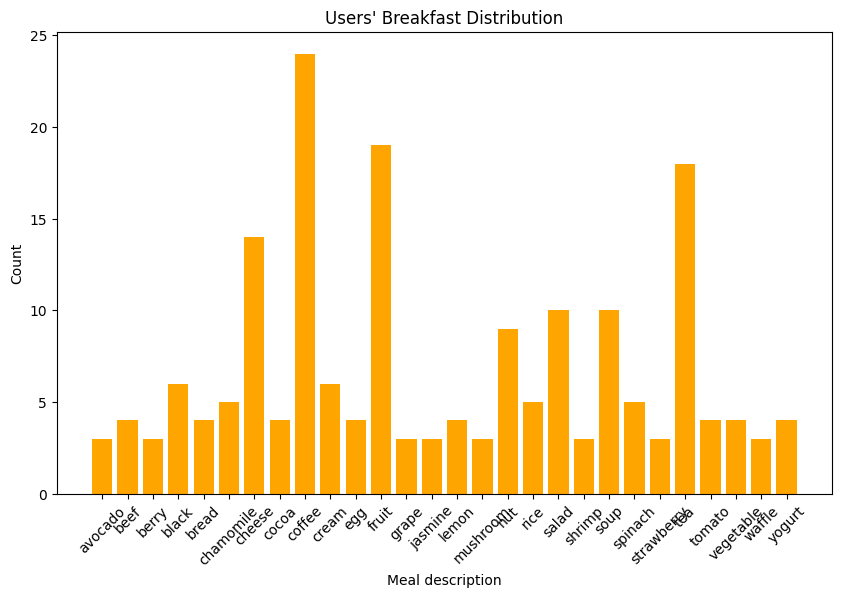

In [ ]:
from collections import Counter
user_data_breakfast = df[(df['meal_type'] == 'breakfast')]

# Extract keywords during breakfast
result = []

for item in user_data_breakfast['Keywords']:
        if isinstance(item, str):
            result.extend(item.split(','))
result = [item for item in result if item != '']

# Use Counter to count keyword occurrences
keyword_counts = Counter(result)

# Extract keys and values from the dictionary where count > 2
filtered_keys = [key for key, count in keyword_counts.items() if count > 2]
filtered_keys = sorted(filtered_keys)

# Extract keys and values for filtered keys
keys = [key for key in filtered_keys]
values = [keyword_counts[key] for key in filtered_keys]

# Plotting the key-value pairs
plt.figure(figsize=(10, 6))
plt.bar(keys, values, color='orange')
plt.xlabel('Meal description')
plt.ylabel('Count')
plt.title('Users\' Breakfast Distribution')
plt.xticks(rotation=45)
plt.show()

From the above bar graph, we can say that the users consume a variety of foods over the time. The most frequently consumed beverage during breakfast time is coffee followed by tea. Along with that, the users also eat fruits, cheese, nuts, salad and soup regularly.

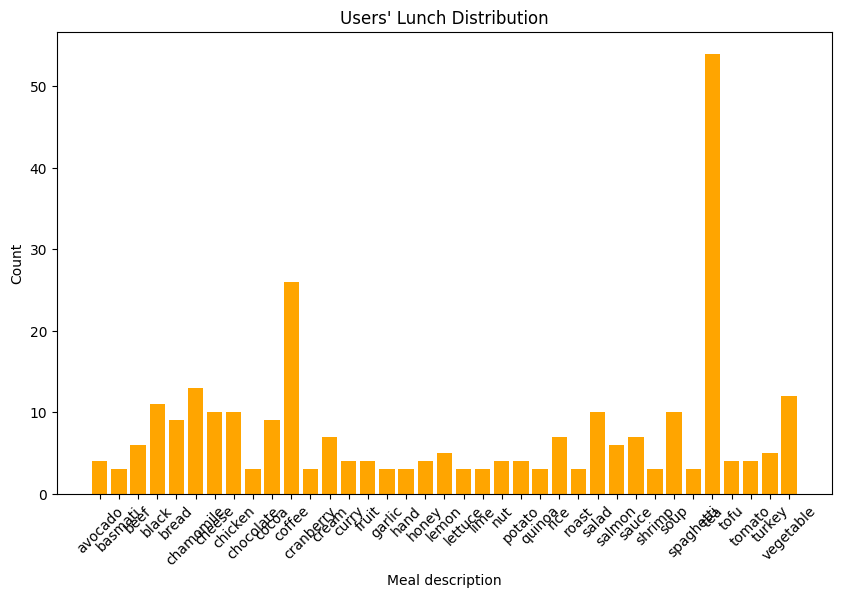

In [ ]:
user_data_lunch = df[(df['meal_type'] == 'lunch')]

# Extract keywords during lunch
result = []

for item in user_data_lunch['Keywords']:
        if isinstance(item, str):
            result.extend(item.split(','))
result = [item for item in result if item != '']

# Use Counter to count keyword occurrences
keyword_counts = Counter(result)

# Extract keys and values from the dictionary where count > 2
filtered_keys = [key for key, count in keyword_counts.items() if count > 2]
filtered_keys = sorted(filtered_keys)

# Extract keys and values for filtered keys
keys = [key for key in filtered_keys]
values = [keyword_counts[key] for key in filtered_keys]

# Plotting the key-value pairs
plt.figure(figsize=(10, 6))
plt.bar(keys, values, color='orange')
plt.xlabel('Meal description')
plt.ylabel('Count')
plt.title('Users\' Lunch Distribution')
plt.xticks(rotation=45)
plt.show()

From the above bar graph, we can say that the most frequently consumed beverage during lunch time is tea. Coffee is also regularly drunk. Vegetables along with salad and soup are the most consumed food items by the users during lunch.

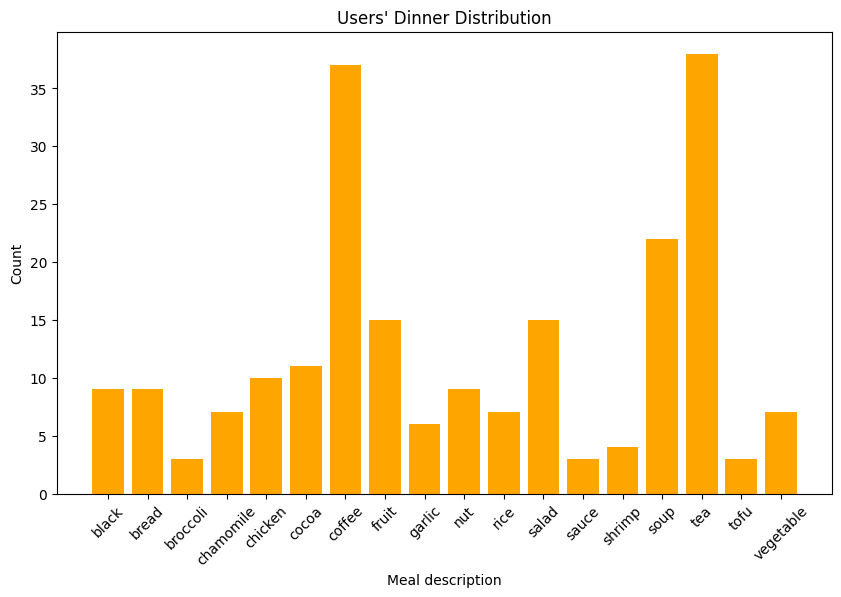

In [ ]:
user_data_dinner = df[(df['meal_type'] == 'dinner')]

# Extract keywords during dinner
result = []

for item in user_data_dinner['Keywords']:
        if isinstance(item, str):
            result.extend(item.split(','))
result = [item for item in result if item != '']

# Use Counter to count keyword occurrences
keyword_counts = Counter(result)

# Extract keys and values from the dictionary where count > 2
filtered_keys = [key for key, count in keyword_counts.items() if count > 2]
filtered_keys = sorted(filtered_keys)

# Extract keys and values for filtered keys
keys = [key for key in filtered_keys]
values = [keyword_counts[key] for key in filtered_keys]

# Plotting the key-value pairs
plt.figure(figsize=(10, 6))
plt.bar(keys, values, color='orange')
plt.xlabel('Meal description')
plt.ylabel('Count')
plt.title('Users\' Dinner Distribution')
plt.xticks(rotation=45)
plt.show()

From the above bar graph, we can say that the most frequently consumed beverage during dinner time is tea and coffee. Soup, salad and fruits are often consumed by users during dinner.

###Find patterns in meal description on weekdays and weekends for all users


*   Finding patterns in meal descriptions on weekdays and weekends for all users can yield valuable insights into the dietary habits and preferences of individuals based on the day of the week.
*   Data is labelled into weekday or weekend depending on the log_time.
*   The result is then displayed into histograms.



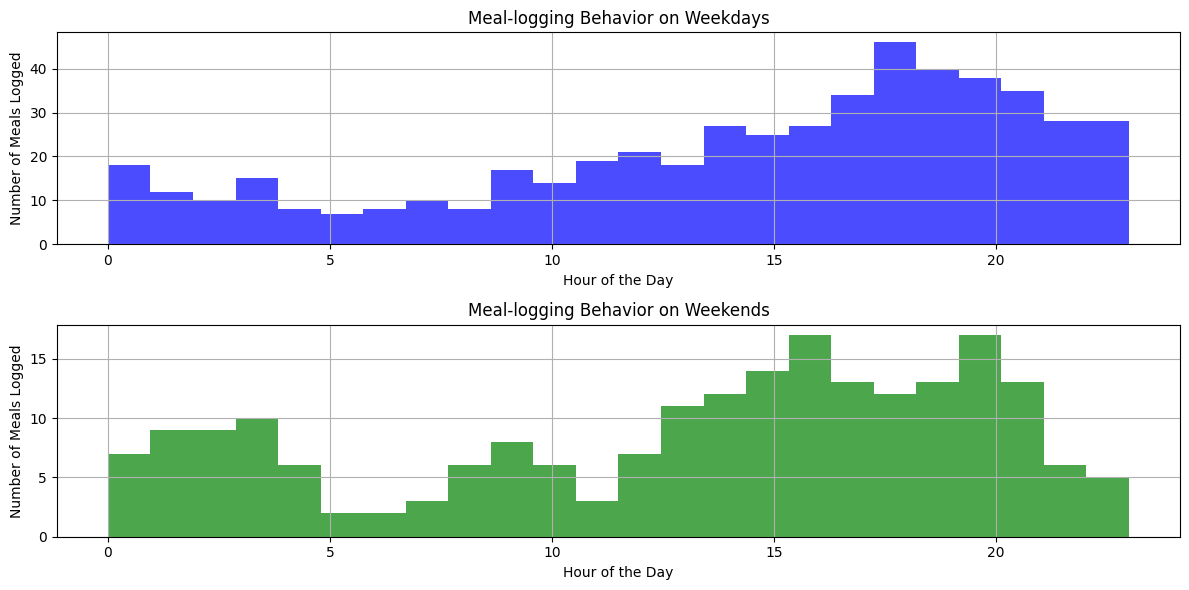

In [ ]:
df['log_time'] = pd.to_datetime(df['log_time'])
df['day_type'] = df['log_time'].dt.weekday.apply(lambda x: 'weekday' if x < 5 else 'weekend')

user_data_weekday = df[(df['day_type'] == 'weekday')]
user_data_weekend = df[(df['day_type'] == 'weekend')]
# Plotting
plt.figure(figsize=(12, 6))

# Plot for weekdays
plt.subplot(2, 1, 1)
plt.hist(user_data_weekday['log_time'].dt.hour, bins=24, color='blue', alpha=0.7)
plt.title('Meal-logging Behavior on Weekdays')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Meals Logged')
plt.grid(True)

# Plot for weekends
plt.subplot(2, 1, 2)
plt.hist(user_data_weekend['log_time'].dt.hour, bins=24, color='green', alpha=0.7)
plt.title('Meal-logging Behavior on Weekends')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Meals Logged')
plt.grid(True)

plt.tight_layout()
plt.show()

From the above histograms, we can say that there are more people logging their breakfast on the weekends rather than weekdays. Lunch and dinner logging counts are comparable during various time-slots.